<a href="https://colab.research.google.com/github/paolo-peretti/conv/blob/main/conv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import torch
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Preproccessing on dataset

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)


# Class labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


I want see a grid of images of the dataset

horse
.............................................



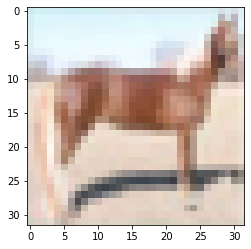

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(training_loader)
images, labels = dataiter.next()
# print(len(images), len(labels))
print(classes[labels[0]])
print('.............................................\n')
imshow(images[0])




Building The Model
============================

One important behavior of ``torch.nn.Module`` is registering parameters.
If a particular ``Module`` subclass has learning weights, these weights
are expressed as instances of ``torch.nn.Parameter``. The ``Parameter``
class is a subclass of ``torch.Tensor``, with the special behavior that
when they are assigned as attributes of a ``Module``, they are added to
the list of that modules parameters. These parameters may be accessed
through the ``parameters()`` method on the ``Module`` class.

As a simple example, here’s a very simple model with two linear layers
and an activation function. We’ll create an instance of it and ask it to
report on its parameters:


In [5]:


class MyModel(torch.nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        
        # CV
        self.conv1 = torch.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5,5))
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5))


        # FC
        self.linear1 = torch.nn.Linear(16*5*5, 120)
        self.linear2 = torch.nn.Linear(120, 84)
        self.linear3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)

        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = x.view(-1, 16*5*5)
        # print(x.shape)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

model = MyModel()
model = model.to(device)

print('The model:')
print(model)



The model:
MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)



Loss Function

In [6]:
loss_fn = torch.nn.CrossEntropyLoss()


In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

The Training Loop

In [8]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            # tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [9]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    # writer.add_scalars('Training vs. Validation Loss',
    #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                 epoch_number + 1)
    # writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.298678608179092
  batch 2000 loss: 2.1538023645877837
  batch 3000 loss: 1.9576441857814788
  batch 4000 loss: 1.8089134730696679
  batch 5000 loss: 1.6921381313800812
  batch 6000 loss: 1.6498097853660583
  batch 7000 loss: 1.590012607604265
  batch 8000 loss: 1.5466075625419617
  batch 9000 loss: 1.5333111011981964
  batch 10000 loss: 1.5106544756889344
  batch 11000 loss: 1.5046806599199771
  batch 12000 loss: 1.4487831450700759
LOSS train 1.4487831450700759 valid 1.4604465961456299
EPOCH 2:
  batch 1000 loss: 1.3708840544521808
  batch 2000 loss: 1.3972678620144725
  batch 3000 loss: 1.334687317378819
  batch 4000 loss: 1.3714989239573478
  batch 5000 loss: 1.300837990909815
  batch 6000 loss: 1.2909905474483967
  batch 7000 loss: 1.3133298760801553
  batch 8000 loss: 1.3002407268732785
  batch 9000 loss: 1.2650187625586986
  batch 10000 loss: 1.2821462855674326
  batch 11000 loss: 1.2592732754051685
  batch 12000 loss: 1.2691824857369065
LOSS train 1.